In [1]:
import pandas as pd
import numpy as np 
import re
% matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import pickle
import time

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [4]:
clean_final = pd.read_csv("./total_news/clean_final_news.csv", encoding = "utf8", index_col = 0)

In [5]:
clean_final["binary_response"] = np.where(clean_final["response"] == "Not fake", 0, 1)

In [6]:
clean_final.head()

,author,published,text,domain_rank,site_url,spam_score,title,response,length,binary_response
0,SAM TANENHAUS,2016-11-20T03:51:00.000+02:00,Privacy Policy Eisenhowers two terms bore this...,98.0,nytimes.com,0.000,Opinion: Donald Trump’s Art of the New Deal?,Not fake,949,0
1,NaN,2016-11-20T00:52:00.000+02:00,Can Trump Save Their Jobs? by Nelson D. Sc...,98.0,nytimes.com,0.000,Carrier Workers for Trump,Not fake,372,0
2,Kathleen Elkins,2016-11-20T06:18:00.000+02:00,"Tuesday, 18 Oct 2016 | 10:25 AM ET CNBC.com Ed...",767.0,cnbc.com,0.008,Tennis star Caroline Wozniacki shares the mone...,Not fake,386,0
3,JEFF SOMMER,2016-11-20T00:04:00.000+02:00,Continue reading the main story Yet it is poss...,98.0,nytimes.com,0.000,Strategies: It’s Not Just the White House. Cha...,Not fake,1005,0
4,James Rufus Koren,2016-11-20T02:42:00.000+02:00,Wells Fargo hit with new sanctions following f...,609.0,latimes.com,0.264,Wells Fargo hit with new sanctions following f...,Not fake,809,0


In [7]:
y_response = clean_final.binary_response.values

In [8]:
fileObject = open('./lem_texts/tri_text.sav','rb')  
tri_lem_comb2 = pickle.load(fileObject)  ## load trigram

In [29]:
%%time
tfidf = TfidfVectorizer(min_df = 0.001, max_df = 0.75)
text_tfidf = tfidf.fit_transform(tri_lem_comb2)

CPU times: user 10.3 s, sys: 440 ms, total: 10.7 s
Wall time: 10.7 s


In [30]:
type(text_tfidf)

scipy.sparse.csr.csr_matrix

In [31]:
%%time
dense_text = text_tfidf.todense()

CPU times: user 1.07 s, sys: 1.85 s, total: 2.92 s
Wall time: 3.4 s


In [32]:
type(dense_text)

numpy.matrixlib.defmatrix.matrix

In [33]:
dense_text2 = np.squeeze(np.asarray(dense_text))

In [34]:
dense_text2[0:10]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [21]:
# dense_real = dense_text[0:23571]
# len(dense_real)

23571

In [22]:
# dense_fake = dense_text[23571:]
# len(dense_fake)

11040

In [19]:
# len(clean_final[clean_final.response == 'Not fake'])

23571

In [20]:
# len(clean_final[clean_final.response == 'fake'])

11040

In [13]:
# Get list of all words in tfidf vocabulary
features = tfidf.get_feature_names()

In [14]:
features[6000:6025]

['embrace',
 'embrace_student_u',
 'embroil',
 'emerge',
 'emerge_market',
 'emergence',
 'emergency',
 'emergency_room',
 'emergency_service',
 'emeritus',
 'emerson',
 'emigrate',
 'emily',
 'eminent',
 'eminent_domain',
 'emirates',
 'emission',
 'emit',
 'emma',
 'emma_watson_dan_stevens',
 'emmanuel',
 'emmy',
 'emotion',
 'emotional',
 'emotionally']

In [15]:
len(features)

20453

In [16]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [25]:
def top_overall_words(text, response, features, cls=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in ids. '''
    if cls:
        ids = np.where(response == cls)
        D = text[ids]
    else:
        D = text

    D[D < min_tfidf] = 0 # so common words across all documents won't dominate - may remove
    tfidf_mean = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_mean, features, top_n)

In [35]:
dense_text2.shape

(34611, 20453)

In [36]:
dense_text2[:10]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [39]:
%%time
# real news top 25
real_top_wd = top_overall_words(dense_text2, y_response, features, cls = 0)

CPU times: user 2.6 s, sys: 437 ms, total: 3.04 s
Wall time: 3.24 s


In [40]:
%%time
# fake news top 25
fake_top_wd = top_overall_words(dense_text2, y_response, features, cls = 1)

CPU times: user 1.56 s, sys: 1.32 s, total: 2.89 s
Wall time: 3.33 s


In [42]:
fake_top_wd

,feature,tfidf
0,trump,0.025801
1,clinton,0.015719
2,hillary,0.014877
3,russia,0.011192
4,fbi,0.010740
5,email,0.009025
6,hillary_clinton,0.009001
7,vote,0.008890
8,obama,0.008068
9,election,0.007890


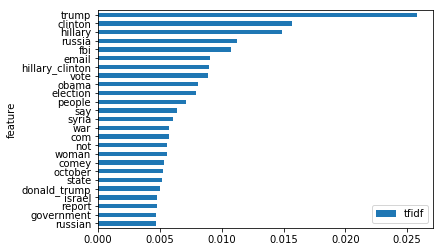

In [54]:
plt.figure(figsize=(12,6))
fake_top_wd.sort_values(by = 'tfidf', ascending=True).plot.barh(x ='feature')

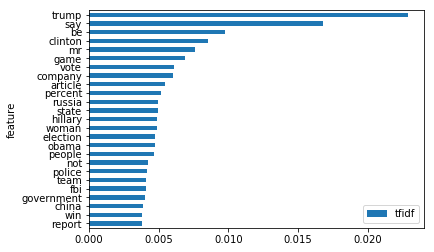

In [55]:
plt.figure(figsize=(12,6))
real_top_wd.sort_values(by = 'tfidf', ascending=True).plot.barh(x ='feature')